In [90]:
from keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dense, Flatten
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from keras import optimizers

from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import re
import string
from keras.utils import np_utils
import pandas as pd
import numpy as np

# Importing data form the stanford datasets and Cornell polarity files
fos  = 'original_rt_snippets.txt'
fp = 'rt-polarity.pos'
fn = 'rt-polarity.neg'
fall = pd.read_csv('datasetSentences.txt',sep = "\t",header = 0)
fsplit = pd.read_csv('datasetSplit.txt', delimiter = ",", header = 0)

#preprocessing data for comparing and other uses
def preprocessing(line):
    newline = line
    newline = newline.lower()
    newline = re.sub('<.*?>', '',newline)        
    newline = re.sub('<[a-zA-Z]','',newline)
    newline = re.sub(r'[^\w]','',newline)        
    newline = re.sub(r'[0-9]','',newline)        
    newline = re.sub(r'[^\x00-\x7f]','',newline)
    return newline
#Splitting lines fumction to store data
def wordstolist(line):
    newline = line
    newline = newline.lower()
    newline = re.sub(r'\d+', '', newline)
    newline = newline.translate(str.maketrans('', '', string.punctuation))
    newline = newline.strip()
    return newline
def filterlines(line):
    line= line.lower()
    line = re.sub(r'[^\w]','',line)
    line = re.sub(r'[0-9]','',line)
    line = re.sub(r'[^\x00-\x7f]','',line)
    line = line.replace("lrb", "")
    line = line.replace("rrb","")
    return line
   
    
sf = []
sp = []
sn = []
    
sf = []

#reading the data from original file and positive/negative files for comparision later
with open(fos, 'rt', encoding = 'latin-1') as f:
    for each_line in f:
        each_line = preprocessing(each_line) 
        sf.append(each_line)    
sp=[]
with open(fp,'rt',encoding='latin-1') as f:
    for each_line in f:
        each_line = preprocessing(each_line)
        sp.append(each_line)
sn=[]
with open(fn,'rt',encoding='latin-1') as f:
    for each_line in f:
        each_line = preprocessing(each_line)
        sn.append(each_line)


#Divinding and storing labels of lines based on their presence in Positive or negative
labelsall = []
for line in sf:
    if any(line == text for text in sp):
        labelsall.append(1)
    elif any(line == text for text in sn):
        labelsall.append(0)
        #Through by lot of preprocessing process we get to know that there is one sentence which doesn't belong to any of the files 
    elif line =="ihavenoproblemwithdifficultmoviesormoviesthatasktheaudiencetomeetthemhalfwayandconnectthedotsinsteadofhavingthingsallspelledoutbutfirstyouhavetogivetheaudienceareasontowanttoputforthateffort" :
#       print('new')
        labelsall.append(0)
    else:
        print (line)
        
#index finder
def indSent(sen,allsen):
    for ind in range(len(allsen)):
        if sen in allsen[ind]:
            return ind

        
labels=[]
for sent in list(fall["sentence"].values):
    sent= filterlines(sent)
    index = indSent(sent,sf)
    labels.append(labelsall[index])
    sf[index]= sf[index].replace(sent,"$$",1) 
fall["labels"]=labels

listall,listwords = [],[]
trainind,testind,devind=[],[],[]
totallabels,trainlabels,devlabels,testlabels=[],[],[],[]
    
for line in fall['sentence']:
    exclude = set(string.punctuation)
    line = ''.join(ch for ch in line if ch not in exclude)
    listwords=[]
    for word in line.split():
        listwords.append(word)
    listall.append(listwords)

#storing indexes which will be used later to find Labels
for k,i in enumerate(fsplit['splitset_label']):
    if i==1:
        trainind.append(k+1)
    if i==2:
        testind.append(k+1)
    if i==3:
        devind.append(k+1)
    
for i in fall['labels']:
    totallabels.append(i)

#creasting test dev train labels
for i in trainind:
    trainlabels.append(totallabels[i-1])
for i in devind:
    devlabels.append(totallabels[i-1])
for i in testind:
    testlabels.append(totallabels[i-1])
    
#Using tokenizer to find all words and max integers
tokenizer = Tokenizer()
# Calculating the frequency of words
tokenizer.fit_on_texts(listall)
# Convert array of sentences to list of sequences of integers
sequences = tokenizer.texts_to_sequences(listall)

# Dictionary keeping track of words to integer index
word_index = tokenizer.word_index

# Convert the array of sequences(of integers) to 2D array with padding
data = pad_sequences(sequences)
    
listtrain=[]
listdev=[]
listtest=[]

#creating train,dev,test lists of 2d arrays form data which will used as arrays later
for i in trainind:
    listtrain.append(list(data[i-1]))
for i in devind:
    listdev.append(list(data[i-1]))
for i in testind:
    listtest.append(list(data[i-1]))
    

#### Main driver fucntion to create models with arguments like Modelname, hidden Units, seq len, Dimensions, LR

In [40]:

def main(rnn_model,hiddenunits,seqlen,dim,learningrate):
    embeddings_index = {}
    print("*************************************************************************")
    print( "Model = "+ str(rnn_model) + " hiddenunits = "+str(hiddenunits) +" seqlen=" + str(seqlen)+" GloveDim="+str(dim) + "Learningrate="+ str(learningrate))
    if dim==50:
        f = open('glove.6B.50d.txt','rt',encoding = 'utf8')
    if dim==100:
        f = open('glove.6B.100d.txt','rt',encoding = 'utf8')
    if dim==300:
        f = open('glove.6B.300d.txt','rt',encoding = 'utf8')
    for line in f:
        values = line.split()
        word = values[0]
        #print(word)
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close() 
    print('Found %s word vectors.' % len(embeddings_index))
    
    embedding_matrix = np.zeros((len(word_index) + 1, dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
            
    # Construct the RNN model-SimpleRNN, LSTM, GRU    
    model = Sequential()
    
    ## Add embedding layer to convert integer encoding to word embeddings(the model learns the
    ## embedding matrix during training), embedding matrix has max_vocab as no. of rows and chosen
    ## no. of columns i.e DIMENSIONS _DIM
    model.add(Embedding(input_dim=(len(word_index) + 1), output_dim=dim,
                        weights = [embedding_matrix],
                        input_length=52, trainable = False, mask_zero =True))
    
    #adding model type based on Input
    if rnn_model == 'SimpleRNN':
        model.add(SimpleRNN(units=hiddenunits,input_shape=[None,seqlen],return_sequences=False))
    elif rnn_model == 'LSTM':
        model.add(LSTM(units=hiddenunits))
    else:
        model.add(GRU(units=hiddenunits))

    model.add(Dense(1, activation='sigmoid'))
    adam = optimizers.Adam(lr = learningrate)
    model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
    print(model.summary())

    return model



In [41]:
#plotting function of history-loss and accuracy graphs of training and val/dev data 
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('acc')
    plt.plot(hist['epoch'], hist['acc'],
               label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'],
               label = 'Val Accuracy')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
    plt.ylim([0,5])
    plt.legend()
    plt.show()    
    


*************************************************************************
Model = SimpleRNN hiddenunits = 128 seqlen=52 GloveDim=100Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 52, 100)           1937800   
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 128)               29312     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 1,967,241
Trainable params: 29,441
Non-trainable params: 1,937,800
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 8s - loss: 0.6856 - acc: 0.5661 - val_loss: 0.6344 - val_acc: 0.6412
Epoch 2/5
 - 5s - loss: 0.6200 - acc: 0.6609 - val_loss: 0.5903 - val_acc: 0.6

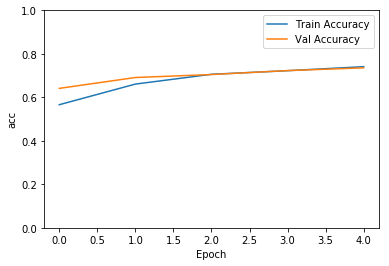

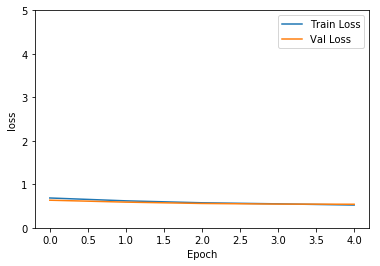

*************************************************************************
Model = SimpleRNN hiddenunits = 64 seqlen=52 GloveDim=100Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 52, 100)           1937800   
_________________________________________________________________
simple_rnn_18 (SimpleRNN)    (None, 64)                10560     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 1,948,425
Trainable params: 10,625
Non-trainable params: 1,937,800
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 7s - loss: 0.7009 - acc: 0.5487 - val_loss: 0.6720 - val_acc: 0.5867
Epoch 2/5
 - 4s - loss: 0.6498 - acc: 0.6195 - val_loss: 0.6328 - val_acc: 0.65

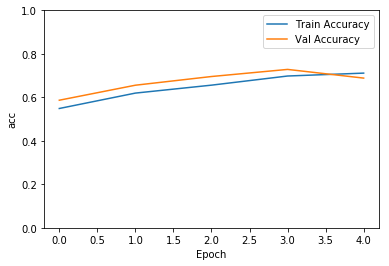

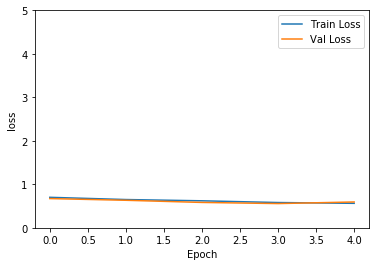

*************************************************************************
Model = SimpleRNN hiddenunits = 32 seqlen=52 GloveDim=100Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 52, 100)           1937800   
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 32)                4256      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 1,942,089
Trainable params: 4,289
Non-trainable params: 1,937,800
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 7s - loss: 0.7150 - acc: 0.5359 - val_loss: 0.6892 - val_acc: 0.5613
Epoch 2/5
 - 4s - loss: 0.6670 - acc: 0.5948 - val_loss: 0.6541 - val_acc: 0.634

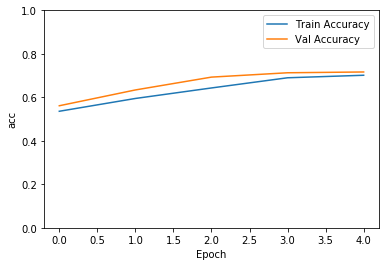

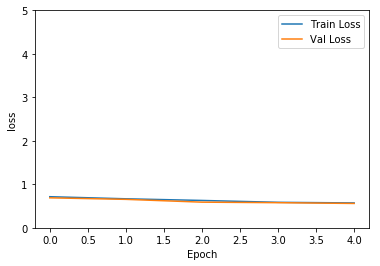

In [45]:
c

#### Our train accuracy: 74.1%, Val Accuracy: 73.5% -for Hidden units = 128, DIM =100 and sequence length = 52

#### Our train accuracy: 71.14%, Val Accuracy: 68.85% -for Hidden units = 64, DIM =100 and sequence length = 52

#### Our train accuracy: 70.2%, Val Accuracy: 71.7% -for Hidden units = 32, DIM =100 and sequence length = 52


*************************************************************************
Model = SimpleRNN hiddenunits = 128 seqlen=52 GloveDim=50Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 52, 50)            968900    
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, 128)               22912     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 991,941
Trainable params: 23,041
Non-trainable params: 968,900
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 8s - loss: 0.6856 - acc: 0.5734 - val_loss: 0.6363 - val_acc: 0.6358
Epoch 2/5
 - 5s - loss: 0.6246 - acc: 0.6575 - val_loss: 0.5945 - val_acc: 0.6830
E

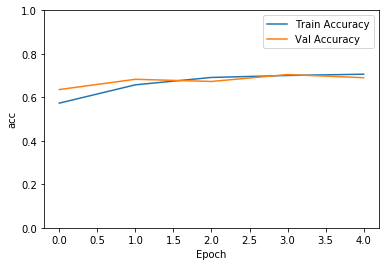

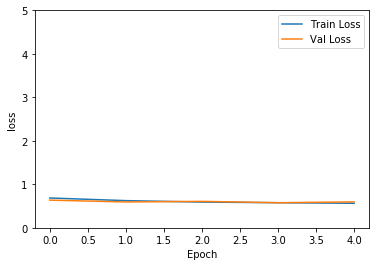

*************************************************************************
Model = SimpleRNN hiddenunits = 64 seqlen=52 GloveDim=50Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 52, 50)            968900    
_________________________________________________________________
simple_rnn_21 (SimpleRNN)    (None, 64)                7360      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 976,325
Trainable params: 7,425
Non-trainable params: 968,900
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 8s - loss: 0.6880 - acc: 0.5581 - val_loss: 0.6715 - val_acc: 0.5867
Epoch 2/5
 - 4s - loss: 0.6603 - acc: 0.6031 - val_loss: 0.6490 - val_acc: 0.6176
Epo

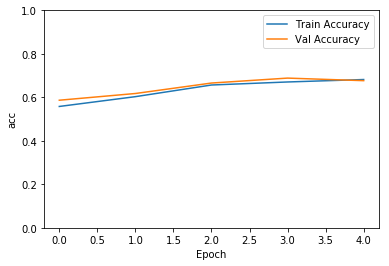

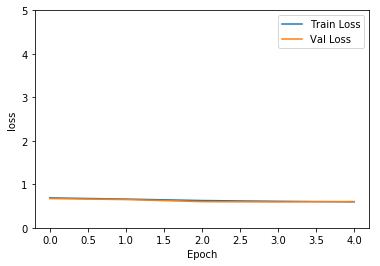

*************************************************************************
Model = SimpleRNN hiddenunits = 32 seqlen=52 GloveDim=50Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 52, 50)            968900    
_________________________________________________________________
simple_rnn_22 (SimpleRNN)    (None, 32)                2656      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 971,589
Trainable params: 2,689
Non-trainable params: 968,900
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 8s - loss: 0.7254 - acc: 0.5062 - val_loss: 0.6970 - val_acc: 0.5495
Epoch 2/5
 - 4s - loss: 0.6872 - acc: 0.5561 - val_loss: 0.6771 - val_acc: 0.5840
Epo

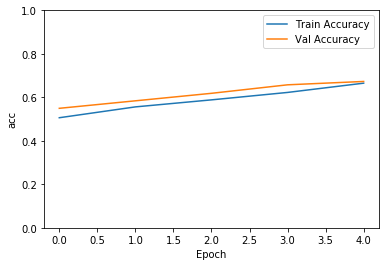

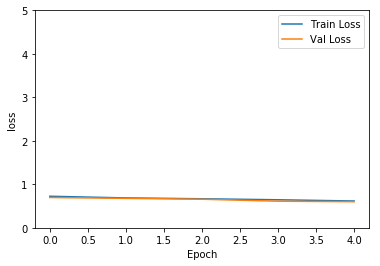

In [46]:
    ##seq 52, dim 50 while changing hidden units
    model128_52_50 = main('SimpleRNN',128,52,50,0.001)
    history = model128_52_50.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    model64_52_50 = main('SimpleRNN',64,52,50,0.001)
    history = model64_52_50.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    model32_52_50 = main('SimpleRNN',32,52,50,0.001)
    history = model32_52_50.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    

#### Our train accuracy: 70.7%, Val Accuracy: 69.0% -for Hidden units = 128, DIM =50 and sequence length = 52

#### Our train accuracy: 68.19%, Val Accuracy: 67.67% -for Hidden units = 64, DIM =50 and sequence length = 52

#### Our train accuracy: 66.5%, Val Accuracy: 67.3% -for Hidden units = 32, DIM =50 and sequence length = 52

*************************************************************************
Model = SimpleRNN hiddenunits = 128 seqlen=52 GloveDim=300Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 52, 300)           5813400   
_________________________________________________________________
simple_rnn_23 (SimpleRNN)    (None, 128)               54912     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 5,868,441
Trainable params: 55,041
Non-trainable params: 5,813,400
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 10s - loss: 0.6517 - acc: 0.6193 - val_loss: 0.5842 - val_acc: 0.7021
Epoch 2/5
 - 6s - loss: 0.5355 - acc: 0.7314 - val_loss: 0.5407 - val_acc: 0.

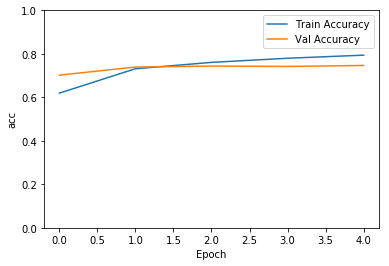

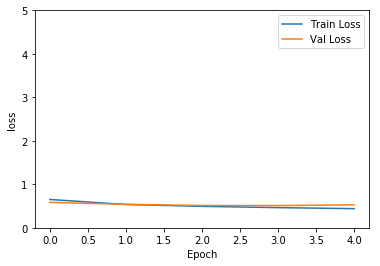

*************************************************************************
Model = SimpleRNN hiddenunits = 64 seqlen=52 GloveDim=300Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 52, 300)           5813400   
_________________________________________________________________
simple_rnn_24 (SimpleRNN)    (None, 64)                23360     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 5,836,825
Trainable params: 23,425
Non-trainable params: 5,813,400
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 9s - loss: 0.6904 - acc: 0.5662 - val_loss: 0.6235 - val_acc: 0.6421
Epoch 2/5
 - 5s - loss: 0.5755 - acc: 0.7031 - val_loss: 0.5408 - val_acc: 0.73

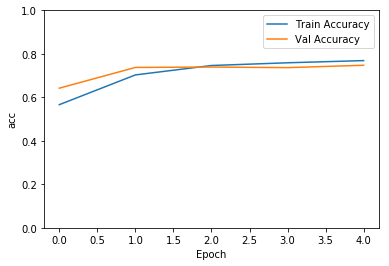

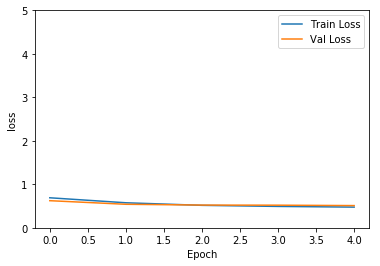

*************************************************************************
Model = SimpleRNN hiddenunits = 32 seqlen=52 GloveDim=300Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 52, 300)           5813400   
_________________________________________________________________
simple_rnn_25 (SimpleRNN)    (None, 32)                10656     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33        
Total params: 5,824,089
Trainable params: 10,689
Non-trainable params: 5,813,400
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 9s - loss: 0.7011 - acc: 0.5475 - val_loss: 0.6631 - val_acc: 0.5995
Epoch 2/5
 - 4s - loss: 0.6420 - acc: 0.6351 - val_loss: 0.5997 - val_acc: 0.68

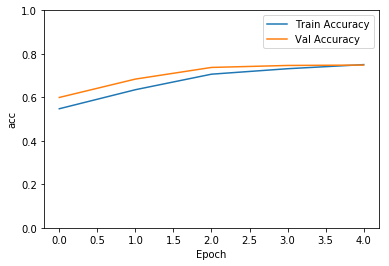

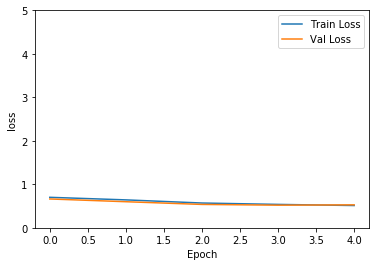

In [47]:
    ###seq 52, dim 300 while changing hidden units
    model128_52_300 = main('SimpleRNN',128,52,300,0.001)
    history = model128_52_300.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    model64_52_300 = main('SimpleRNN',64,52,300,0.001)
    history = model64_52_300.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    model32_52_300 = main('SimpleRNN',32,52,300,0.001)
    history = model32_52_300.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)

#### Our train accuracy: 79.4%, Val Accuracy: 74.6% -for Hidden units = 128, DIM =300 and sequence length = 52

#### Our train accuracy: 76.9%, Val Accuracy: 74.8% -for Hidden units = 64, DIM =300 and sequence length = 52

#### Our train accuracy: 75.0%, Val Accuracy: 74.8% -for Hidden units = 32, DIM =300 and sequence length = 52

*************************************************************************
Model = SimpleRNN hiddenunits = 128 seqlen=100 GloveDim=100Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 52, 100)           1937800   
_________________________________________________________________
simple_rnn_26 (SimpleRNN)    (None, 128)               29312     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 1,967,241
Trainable params: 29,441
Non-trainable params: 1,937,800
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 10s - loss: 0.6784 - acc: 0.5835 - val_loss: 0.6118 - val_acc: 0.6757
Epoch 2/5
 - 5s - loss: 0.5996 - acc: 0.6779 - val_loss: 0.5726 - val_acc: 0

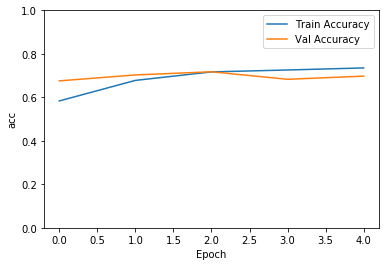

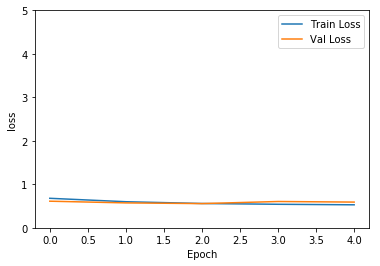

*************************************************************************
Model = SimpleRNN hiddenunits = 64 seqlen=100 GloveDim=100Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 52, 100)           1937800   
_________________________________________________________________
simple_rnn_27 (SimpleRNN)    (None, 64)                10560     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 1,948,425
Trainable params: 10,625
Non-trainable params: 1,937,800
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 8s - loss: 0.7033 - acc: 0.5398 - val_loss: 0.6693 - val_acc: 0.5786
Epoch 2/5
 - 4s - loss: 0.6514 - acc: 0.6166 - val_loss: 0.6181 - val_acc: 0.6

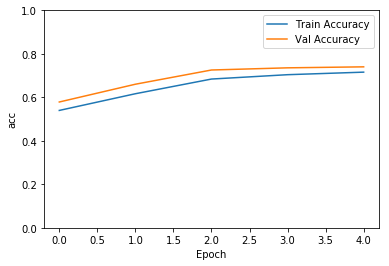

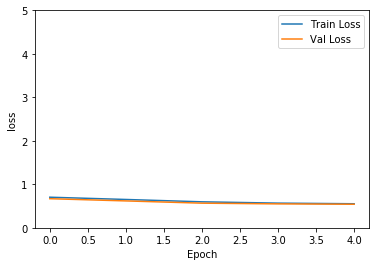

*************************************************************************
Model = SimpleRNN hiddenunits = 32 seqlen=100 GloveDim=100Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 52, 100)           1937800   
_________________________________________________________________
simple_rnn_28 (SimpleRNN)    (None, 32)                4256      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 33        
Total params: 1,942,089
Trainable params: 4,289
Non-trainable params: 1,937,800
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 9s - loss: 0.7245 - acc: 0.5241 - val_loss: 0.6851 - val_acc: 0.5722
Epoch 2/5
 - 4s - loss: 0.6797 - acc: 0.5720 - val_loss: 0.6644 - val_acc: 0.60

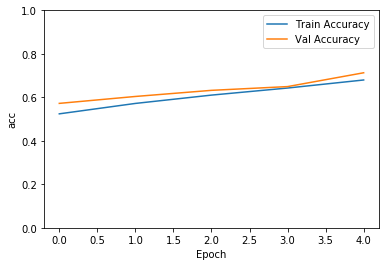

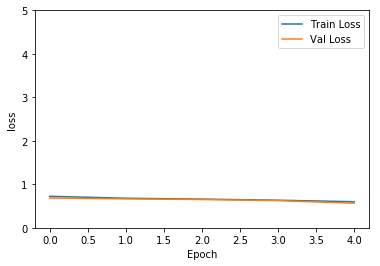

In [48]:
    #seq 100, dim 100 while changing hidden units
    model128_100_100 = main('SimpleRNN',128,100,100,0.001)
    history = model128_100_100.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    model64_100_100 = main('SimpleRNN',64,100,100,0.001)
    history = model64_100_100.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    model32_100_100 = main('SimpleRNN',32,100,100,0.001)
    history = model32_100_100.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)

#### Our train accuracy: 73.5%, Val Accuracy: 69.7% -for Hidden units = 128, DIM =100 and sequence length = 100

#### Our train accuracy: 71.6%, Val Accuracy: 74.0% -for Hidden units = 64, DIM =100 and sequence length = 100

#### Our train accuracy: 68%, Val Accuracy: 71.3% -for Hidden units = 32, DIM =100 and sequence length = 100

*************************************************************************
Model = SimpleRNN hiddenunits = 128 seqlen=100 GloveDim=50Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 52, 50)            968900    
_________________________________________________________________
simple_rnn_29 (SimpleRNN)    (None, 128)               22912     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 991,941
Trainable params: 23,041
Non-trainable params: 968,900
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 10s - loss: 0.7014 - acc: 0.5513 - val_loss: 0.6511 - val_acc: 0.6140
Epoch 2/5
 - 5s - loss: 0.6260 - acc: 0.6476 - val_loss: 0.6336 - val_acc: 0.6431

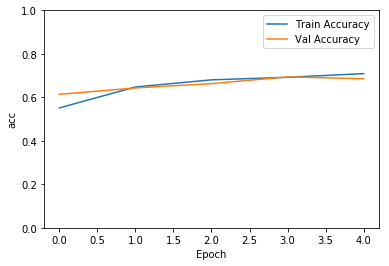

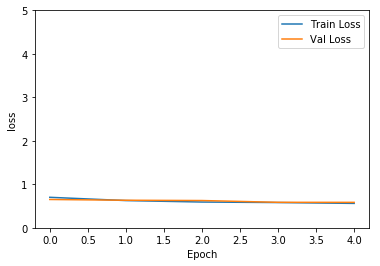

*************************************************************************
Model = SimpleRNN hiddenunits = 64 seqlen=100 GloveDim=50Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 52, 50)            968900    
_________________________________________________________________
simple_rnn_30 (SimpleRNN)    (None, 64)                7360      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 65        
Total params: 976,325
Trainable params: 7,425
Non-trainable params: 968,900
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 9s - loss: 0.7207 - acc: 0.5296 - val_loss: 0.6792 - val_acc: 0.5722
Epoch 2/5
 - 4s - loss: 0.6612 - acc: 0.5990 - val_loss: 0.6453 - val_acc: 0.6503
Ep

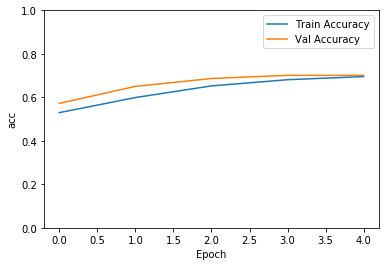

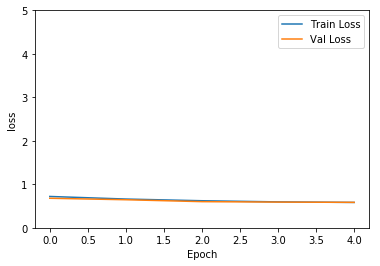

*************************************************************************
Model = SimpleRNN hiddenunits = 32 seqlen=100 GloveDim=50Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 52, 50)            968900    
_________________________________________________________________
simple_rnn_31 (SimpleRNN)    (None, 32)                2656      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 971,589
Trainable params: 2,689
Non-trainable params: 968,900
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 9s - loss: 0.7231 - acc: 0.4890 - val_loss: 0.6962 - val_acc: 0.5395
Epoch 2/5
 - 4s - loss: 0.6768 - acc: 0.5693 - val_loss: 0.6670 - val_acc: 0.5958
Ep

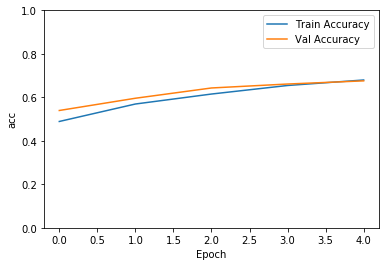

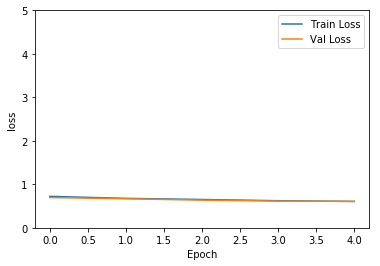

In [49]:
    ##seq 100, dim 50 while changing hidden units
    model128_100_50 = main('SimpleRNN',128,100,50,0.001)
    history = model128_100_50.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    model64_100_50 = main('SimpleRNN',64,100,50,0.001)
    history = model64_100_50.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    model32_100_50 = main('SimpleRNN',32,100,50,0.001)
    history = model32_100_50.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    

#### Our train accuracy: 70.9%, Val Accuracy: 68.6% -for Hidden units = 128, DIM =50 and sequence length = 100

#### Our train accuracy: 69.6%, Val Accuracy: 70.1% -for Hidden units = 64, DIM =50 and sequence length =100

#### Our train accuracy: 68%, Val Accuracy: 67.5% -for Hidden units = 32, DIM =50 and sequence length =100

*************************************************************************
Model = SimpleRNN hiddenunits = 128 seqlen=100 GloveDim=300Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 52, 300)           5813400   
_________________________________________________________________
simple_rnn_32 (SimpleRNN)    (None, 128)               54912     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 5,868,441
Trainable params: 55,041
Non-trainable params: 5,813,400
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 11s - loss: 0.6475 - acc: 0.6179 - val_loss: 0.5374 - val_acc: 0.7384
Epoch 2/5
 - 6s - loss: 0.5241 - acc: 0.7372 - val_loss: 0.5125 - val_acc: 0

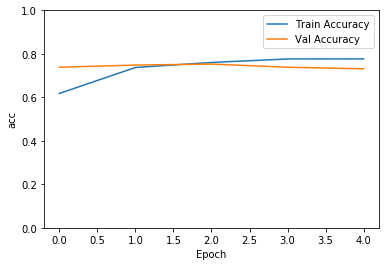

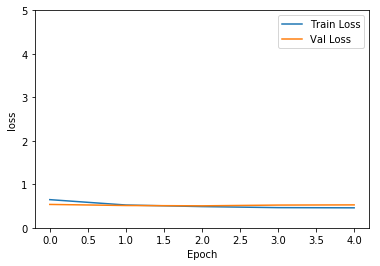

*************************************************************************
Model = SimpleRNN hiddenunits = 64 seqlen=100 GloveDim=300Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 52, 300)           5813400   
_________________________________________________________________
simple_rnn_33 (SimpleRNN)    (None, 64)                23360     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 5,836,825
Trainable params: 23,425
Non-trainable params: 5,813,400
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 10s - loss: 0.6495 - acc: 0.6196 - val_loss: 0.5935 - val_acc: 0.7066
Epoch 2/5
 - 5s - loss: 0.5506 - acc: 0.7163 - val_loss: 0.5170 - val_acc: 0.

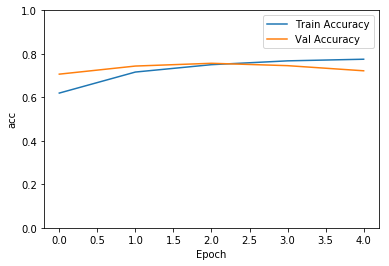

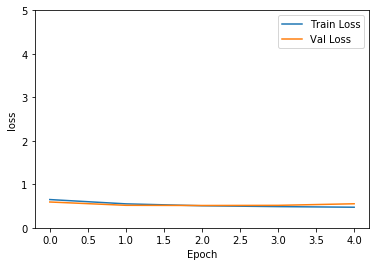

*************************************************************************
Model = SimpleRNN hiddenunits = 32 seqlen=100 GloveDim=300Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 52, 300)           5813400   
_________________________________________________________________
simple_rnn_34 (SimpleRNN)    (None, 32)                10656     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 33        
Total params: 5,824,089
Trainable params: 10,689
Non-trainable params: 5,813,400
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 9s - loss: 0.6988 - acc: 0.5482 - val_loss: 0.6573 - val_acc: 0.6213
Epoch 2/5
 - 5s - loss: 0.6178 - acc: 0.6512 - val_loss: 0.5487 - val_acc: 0.7

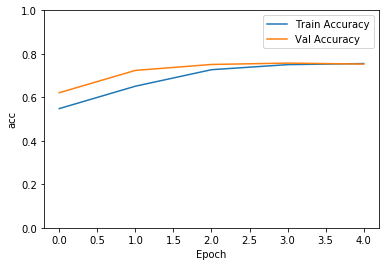

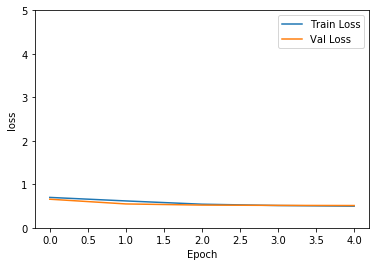

In [50]:
    ##seq 100, dim 300 while changing hidden units
    model128_100_300 = main('SimpleRNN',128,100,300,0.001)
    history = model128_100_300.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    model64_100_300 = main('SimpleRNN',64,100,300,0.001)
    history = model64_100_300.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    model32_100_300 = main('SimpleRNN',32,100,300,0.001)
    history = model32_100_300.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    #main('LSTM',128,52,100,0.001)
    #main('GRU',128,52,100,0.001)

#### Our train accuracy: 77.7%, Val Accuracy: 73.1% -for Hidden units = 128, DIM =300 and sequence length = 100

#### Our train accuracy: 77.5%, Val Accuracy: 72.2% -for Hidden units = 64, DIM =300 and sequence length = 100

#### Our train accuracy: 75.5%, Val Accuracy: 75.3% -for Hidden units = 32, DIM =300 and sequence length = 100

### Observations
#### In our SimpleRNN models, the 300 dimensionsional Glove embeddings seem to help a lot in terms of accuracy and then the hidden seems to increase the accurucy. The seq_Length of 52 which is the maxlength of all sentences seems to work better than the 100 which we used. 

#### We will try out once with a rather small seq length and check the impact again.

*************************************************************************
Model = SimpleRNN hiddenunits = 128 seqlen=20 GloveDim=300Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 52, 300)           5813400   
_________________________________________________________________
simple_rnn_36 (SimpleRNN)    (None, 128)               54912     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 129       
Total params: 5,868,441
Trainable params: 55,041
Non-trainable params: 5,813,400
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 12s - loss: 0.6456 - acc: 0.6285 - val_loss: 0.5542 - val_acc: 0.7203
Epoch 2/5
 - 6s - loss: 0.5258 - acc: 0.7337 - val_loss: 0.5520 - val_acc: 0.

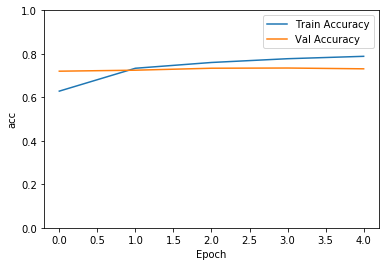

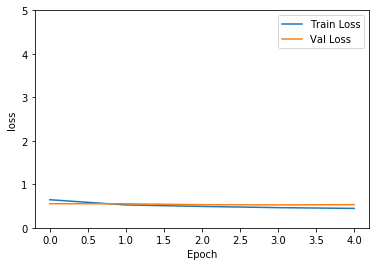

*************************************************************************
Model = SimpleRNN hiddenunits = 256 seqlen=52 GloveDim=300Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 52, 300)           5813400   
_________________________________________________________________
simple_rnn_37 (SimpleRNN)    (None, 256)               142592    
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 257       
Total params: 5,956,249
Trainable params: 142,849
Non-trainable params: 5,813,400
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 15s - loss: 0.6624 - acc: 0.6148 - val_loss: 0.5530 - val_acc: 0.7057
Epoch 2/5
 - 9s - loss: 0.5294 - acc: 0.7367 - val_loss: 0.5647 - val_acc: 0

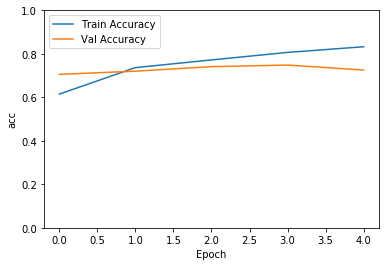

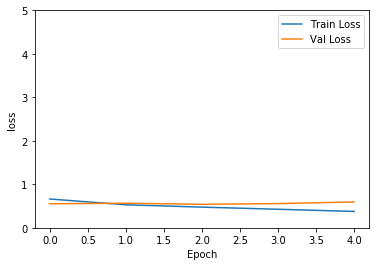

In [52]:
    model128_20_300 = main('SimpleRNN',128,20,300,0.001)
    history = model128_20_300.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    
    model128_20_300 = main('SimpleRNN',256,52,300,0.001)
    history = model128_20_300.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)

#### Our train accuracy: 78.9%, Val Accuracy: 73.12% -for Hidden units = 128, DIM =300 and sequence length = 20
#### Our train accuracy: 83.2%, Val Accuracy: 72.57% -for Hidden units = 256, DIM =300 and sequence length = 52

In [ ]:
#### In the above cases, Decreasing the sequence lenght seems to help training accuracy but the val accuracy goes down, it tries to learn more accordingly to the training accuracy

#### In the 256 Hidden units case, the increased number of hidden units are trying to find patterns more specific to hidden data and not much generalized. 

#### Both cases are helping training but not much on validation

### We got out best model in RNN using: 

### TrainAcc = 79.4%  and Val Accuracy = 74.6%

###  Dim = 300, Hidden units = 128, seq len = 52, LR = 0.001

#### We try it on LSTM and GRU



*************************************************************************
Model = LSTM hiddenunits = 128 seqlen=52 GloveDim=300Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 52, 300)           5813400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 129       
Total params: 6,033,177
Trainable params: 219,777
Non-trainable params: 5,813,400
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 33s - loss: 0.6166 - acc: 0.6588 - val_loss: 0.5245 - val_acc: 0.7457
Epoch 2/5
 - 25s - loss: 0.5158 - acc: 0.7438 - val_loss: 0.5102 - val_acc: 0.752

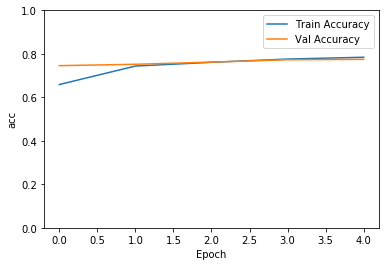

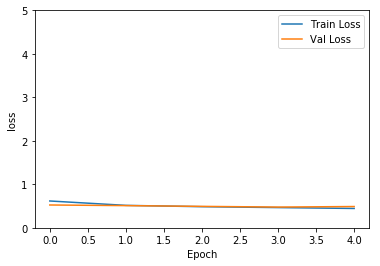

*************************************************************************
Model = GRU hiddenunits = 128 seqlen=52 GloveDim=300Learningrate=0.001
Found 400000 word vectors.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 52, 300)           5813400   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               164736    
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 129       
Total params: 5,978,265
Trainable params: 164,865
Non-trainable params: 5,813,400
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/5
 - 26s - loss: 0.6317 - acc: 0.6330 - val_loss: 0.5293 - val_acc: 0.7321
Epoch 2/5
 - 19s - loss: 0.5244 - acc: 0.7412 - val_loss: 0.4956 - val_acc: 0.7611

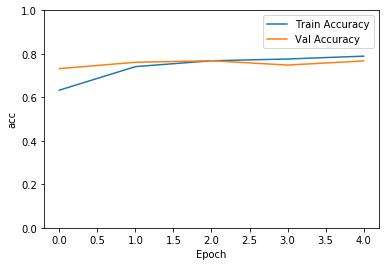

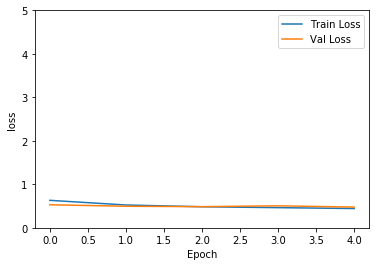

In [53]:
    modelLSTM_128_52_300 = main('LSTM',128,52,300,0.001)
    history = modelLSTM_128_52_300.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)
    
    modelGRU_128_52_300 = main('GRU',128,52,300,0.001)
    history = modelGRU_128_52_300.fit(np.array(listtrain), np.array(trainlabels), epochs=5,verbose=2, batch_size=256, validation_data=(np.array(listdev),np.array(devlabels)))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plot_history(history)

### Our train accuracy: 78.4%, Val Accuracy: 77.4% -for Hidden units = 128, DIM =300 and sequence length = 20
### Our train accuracy: 78.9%, Val Accuracy: 76.8% -for Hidden units = 256, DIM =300 and sequence length = 52

### Our LSTM model has lost 1% accuracy in training compared to SimpleRNN but gained a significant ~ +4% in Validation

### Our GRU model has lost 0.5% accuracy in training compared to SimpleRNN but gained a significant ~ +3.2% in Validation

### Therefore, LSTM gave us the best results and we will be trying it on Test data

In [87]:
testpred = modelLSTM_128_52_300.predict_classes(np.array(listtest))
testacc =  modelLSTM_128_52_300.evaluate(np.array(listtest), np.array(testlabels))
print(testpred)


2210/2210 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 7s 3ms/step
[[1]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]


In [65]:
##Precision ##Recall ##F1 Measure
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(testlabels,testpred ).ravel()

In [81]:
#precision = tp/tp+fp
precision= tp/(tp+fp)

#recall = tp/tp+fn
recall = tp/(tp+fn)

f1score= 2*precision/(recall+precision)

In [85]:
print("Precision = ", precision)
print("Recall = ", recall)
print("F1 Score = ", f1score)

Precision =  0.7450628366247756
Recall =  0.7742537313432836
F1 Score =  0.9807868252516011


#### Precision =  0.7450628366247756
#### Recall =  0.7742537313432836
#### F1 Score =  0.9807868252516011

### Conclusion
#### We got best results from LSTM and worst form SimpleRNN and the GRU worked significantly well alongside LSTM.
#### Both gru and lstm use Control gates to solve vanishing gradient problem.
#### LSTM works better and gives good performance because of the the control units but it is not resource efficient for large training data

#### GRUs are simpler and give decent performance while being resource efficient especially in large training datasets. They even outperform LSTMs in some cases which require  long distance relationships
#### In our case, even though LSTMs and GRUs give similar performance(LSTMs slightly better), we would choose GRUs for in case of larger training data because of simplicity and speed of training.